# Simple Time-Aware Neural Network Visualization

Direct visualization using `numba_ga.py` functions with no classes.
Simple 1→1 network to see how output changes with time and input patterns.

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

import numpy as np
import matplotlib.pyplot as plt
from numba_ga import (
    initialize_parameters,
    predict_individual,
    compute_layer_indices
)

plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.figsize'] = (12, 6)

## Setup Simple 1→1 Network

In [2]:
# Simple network: 1 input → 1 output
layer_sizes = np.array([1, 1], dtype=np.int64)
activations = np.array([3], dtype=np.int64)  # Tanh activation

# Initialize parameters
parameters = initialize_parameters(layer_sizes, seed=42)

# Set simple values for visualization
parameters[0] = 0.5   # weight
parameters[1] = 0.1   # bias
parameters[2] = 0.9   # alpha (memory strength)

# Pre-compute indices
param_indices, neuron_indices = compute_layer_indices(layer_sizes)

print(f"Network: {layer_sizes[0]} → {layer_sizes[1]}")
print(f"Weight: {parameters[0]:.2f}")
print(f"Bias: {parameters[1]:.2f}")
print(f"Alpha: {parameters[2]:.2f}")
print(f"Parameters shape: {parameters.shape}")

Network: 1 → 1
Weight: 0.50
Bias: 0.10
Alpha: 0.90
Parameters shape: (3,)


## Test Binary Patterns


Sparse: 1000100010001
Output range: 0.027 to 0.076
Final 3 outputs: [np.float64(0.03664298157022515), np.float64(0.029473766476035845), np.float64(0.0755240192725401)]

Alternating: 1010101010101
Output range: 0.042 to 0.091
Final 3 outputs: [np.float64(0.0907157715522495), np.float64(0.058276875129320345), np.float64(0.09075544399626748)]

Burst: 1111111000000000
Output range: 0.022 to 0.126
Final 3 outputs: [np.float64(0.022597415633117488), np.float64(0.02200768383908922), np.float64(0.021694269926205774)]


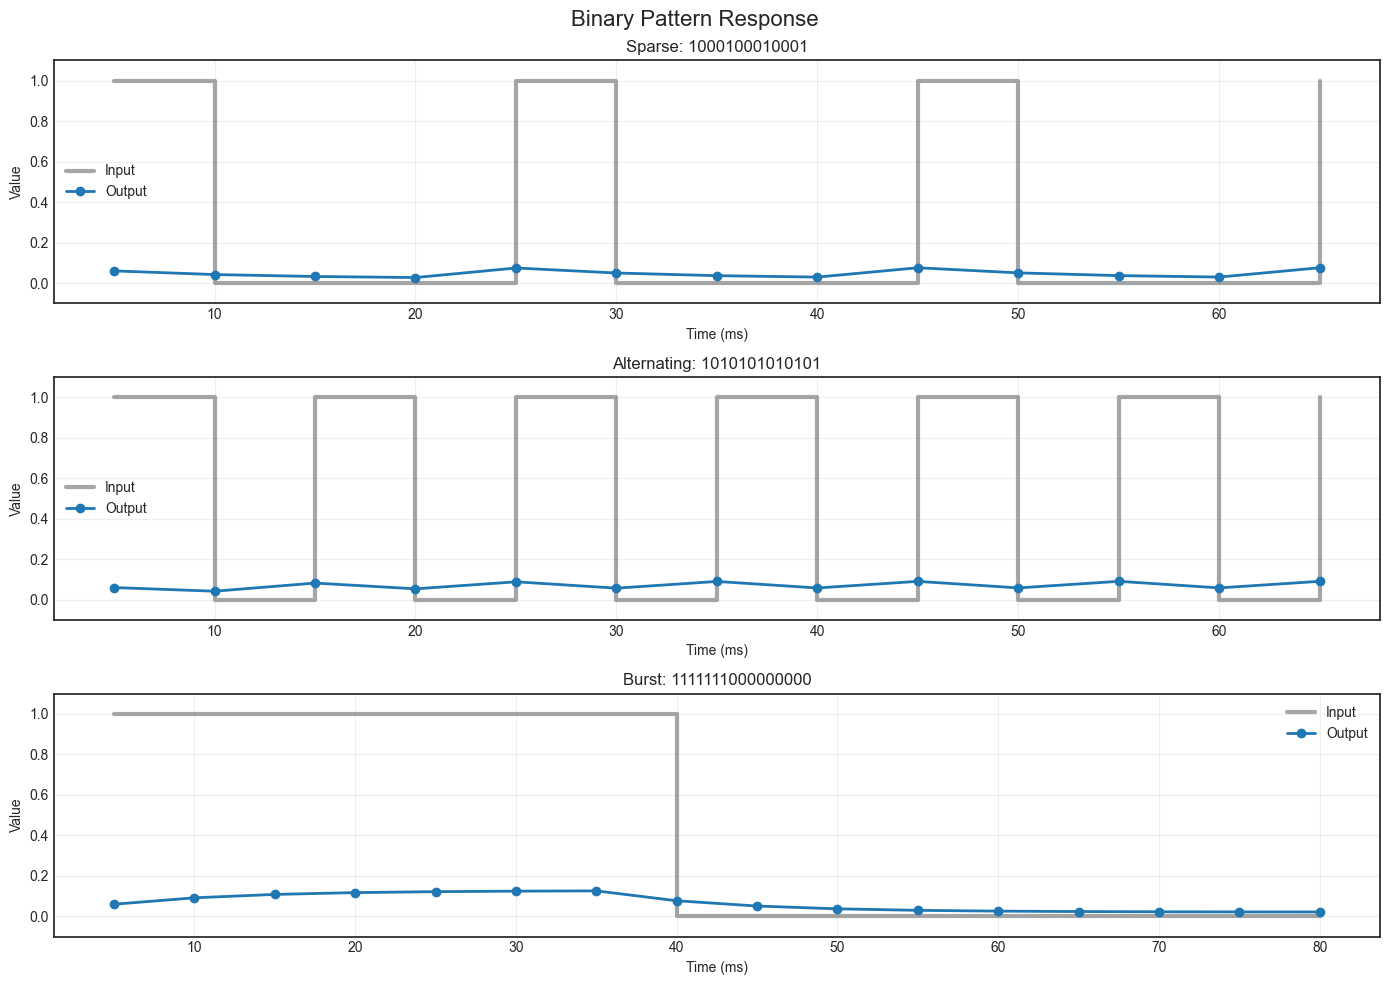

In [3]:
# Test patterns
patterns = {
    'Sparse': '1000100010001',      # Sparse pulses
    'Alternating': '1010101010101',  # Regular alternating 
    'Burst': '1111111000000000'      # Burst then silence
}

time_step = 5.0  # 5ms between inputs

fig, axes = plt.subplots(len(patterns), 1, figsize=(14, 10))
fig.suptitle('Binary Pattern Response', fontsize=16)

for idx, (pattern_name, pattern_str) in enumerate(patterns.items()):
    # Reset state for each pattern
    prev_states = np.zeros(1, dtype=np.float64)  # 1 neuron
    prev_time = 0.0
    
    times = []
    inputs = []
    outputs = []
    
    current_time = 0.0
    
    for bit_char in pattern_str:
        current_time += time_step
        
        # Convert bit to input
        input_val = float(bit_char)  # '0' → 0.0, '1' → 1.0
        x_vector = np.array([input_val], dtype=np.float64)
        inputs_tuple = (current_time, x_vector)
        
        # Predict
        output, prev_states, _ = predict_individual(
            parameters, layer_sizes, activations, inputs_tuple,
            prev_states, prev_time, param_indices, neuron_indices
        )
        
        times.append(current_time)
        inputs.append(input_val)
        outputs.append(output[0])  # Extract scalar
        
        prev_time = current_time
    
    # Plot
    ax = axes[idx]
    
    # Input as steps
    ax.step(times, inputs, where='post', label='Input', linewidth=3, alpha=0.7, color='gray')
    
    # Output as line
    ax.plot(times, outputs, 'o-', label='Output', linewidth=2, markersize=6)
    
    ax.set_title(f'{pattern_name}: {pattern_str}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.1)
    
    # Print some values
    print(f"\n{pattern_name}: {pattern_str}")
    print(f"Output range: {min(outputs):.3f} to {max(outputs):.3f}")
    print(f"Final 3 outputs: {outputs[-3:][:3]}")

plt.tight_layout()
plt.show()

## Test Different Time Intervals

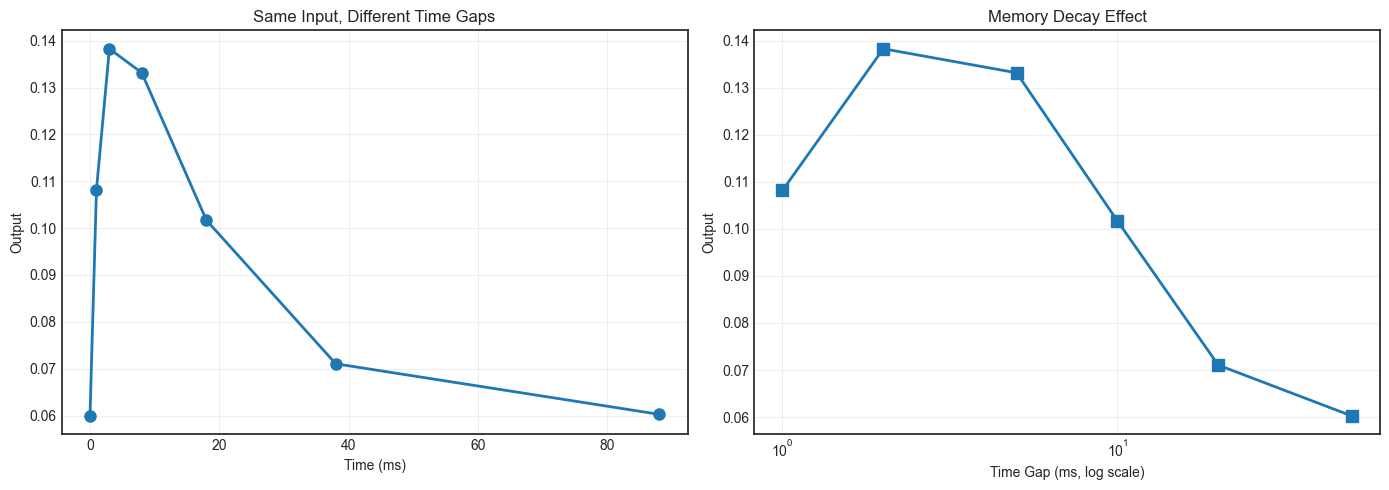


Time Gap Effects:
Gap (ms)	Output
--------------------
     0.0	0.0599
     1.0	0.1082
     2.0	0.1383
     5.0	0.1332
    10.0	0.1017
    20.0	0.0710
    50.0	0.0603


In [4]:
# Same input, different time gaps
input_value = 1.0
time_gaps = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0]  # milliseconds

# Reset state
prev_states = np.zeros(1, dtype=np.float64)
prev_time = 0.0
current_time = 0.0

times = []
outputs = []
gaps = []

# First prediction to establish initial state
x_vector = np.array([input_value], dtype=np.float64)
inputs_tuple = (current_time, x_vector)
output, prev_states, _ = predict_individual(
    parameters, layer_sizes, activations, inputs_tuple,
    prev_states, prev_time, param_indices, neuron_indices
)
times.append(current_time)
outputs.append(output[0])
gaps.append(0.0)
prev_time = current_time

# Test different time gaps
for gap in time_gaps:
    current_time += gap
    
    inputs_tuple = (current_time, x_vector)
    output, prev_states, _ = predict_individual(
        parameters, layer_sizes, activations, inputs_tuple,
        prev_states, prev_time, param_indices, neuron_indices
    )
    
    times.append(current_time)
    outputs.append(output[0])
    gaps.append(gap)
    
    prev_time = current_time

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Time series
ax1.plot(times, outputs, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Output')
ax1.set_title('Same Input, Different Time Gaps')
ax1.grid(True, alpha=0.3)

# Gap vs output
ax2.semilogx(gaps[1:], outputs[1:], 's-', linewidth=2, markersize=8)
ax2.set_xlabel('Time Gap (ms, log scale)')
ax2.set_ylabel('Output')
ax2.set_title('Memory Decay Effect')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results
print("\nTime Gap Effects:")
print("Gap (ms)\tOutput")
print("-" * 20)
for gap, output in zip(gaps, outputs):
    print(f"{gap:8.1f}\t{output:.4f}")

## Test Different Alpha Values

Alpha 0.1: Output range 0.090 to 0.493
Alpha 0.5: Output range 0.050 to 0.291
Alpha 0.9: Output range 0.029 to 0.070
Alpha 0.99: Output range 0.006 to 0.020


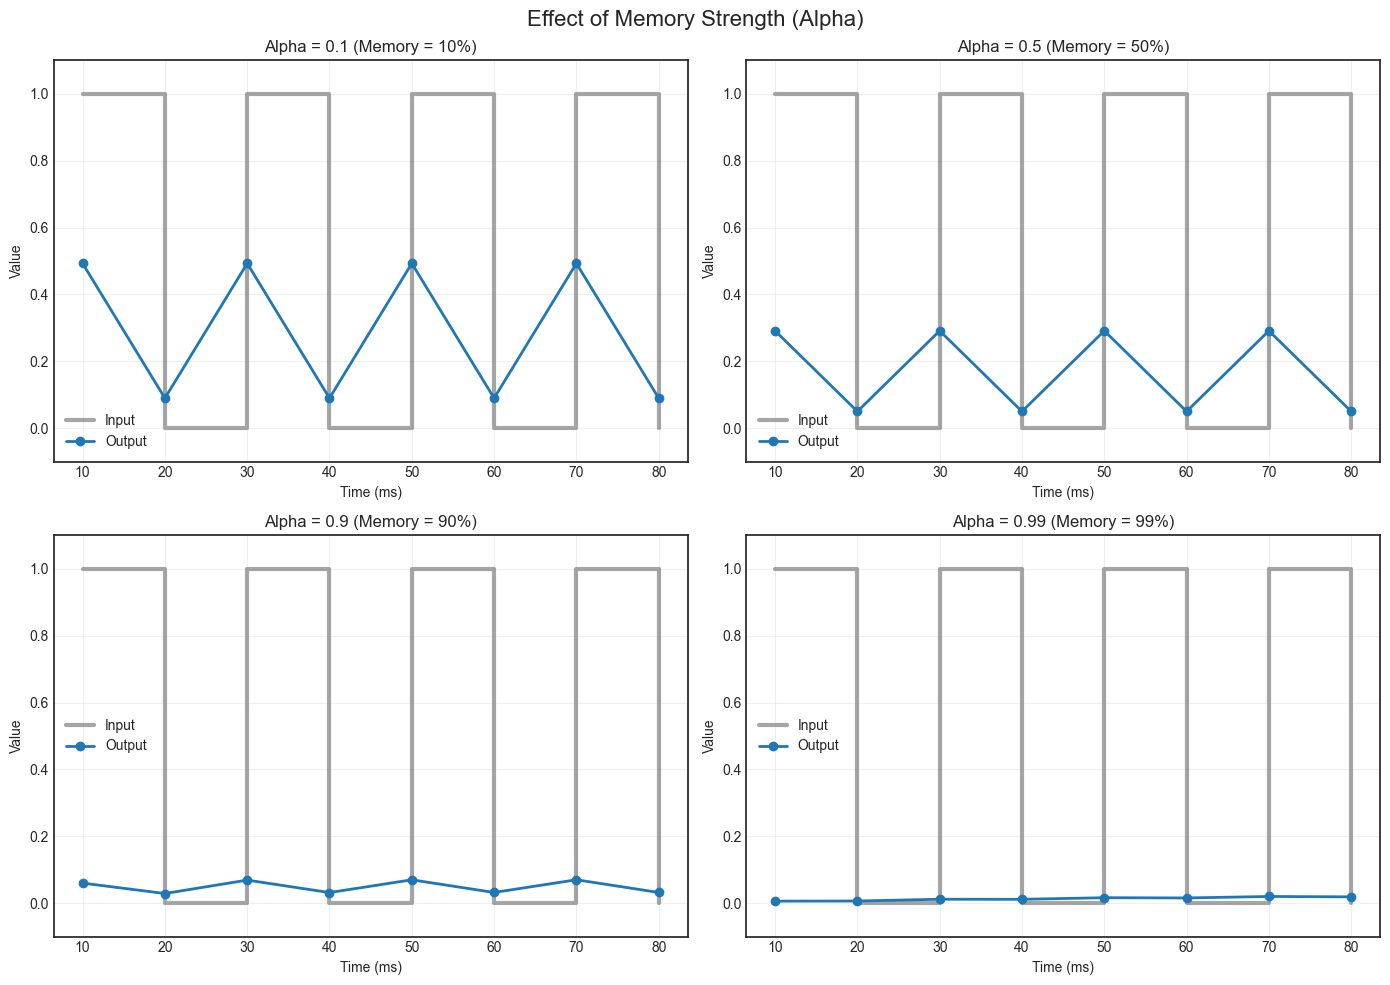

In [5]:
# Test different memory strengths
alphas = [0.1, 0.5, 0.9, 0.99]  # Different memory strengths
pattern = '10101010'  # Simple alternating pattern
time_step = 10.0  # 10ms steps

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
fig.suptitle('Effect of Memory Strength (Alpha)', fontsize=16)

for idx, alpha in enumerate(alphas):
    # Set alpha parameter
    test_params = parameters.copy()
    test_params[2] = alpha  # Set alpha
    
    # Reset state
    prev_states = np.zeros(1, dtype=np.float64)
    prev_time = 0.0
    current_time = 0.0
    
    times = []
    inputs = []
    outputs = []
    
    for bit_char in pattern:
        current_time += time_step
        
        input_val = float(bit_char)
        x_vector = np.array([input_val], dtype=np.float64)
        inputs_tuple = (current_time, x_vector)
        
        output, prev_states, _ = predict_individual(
            test_params, layer_sizes, activations, inputs_tuple,
            prev_states, prev_time, param_indices, neuron_indices
        )
        
        times.append(current_time)
        inputs.append(input_val)
        outputs.append(output[0])
        
        prev_time = current_time
    
    # Plot
    ax = axes[idx]
    ax.step(times, inputs, where='post', label='Input', linewidth=3, alpha=0.7, color='gray')
    ax.plot(times, outputs, 'o-', label='Output', linewidth=2, markersize=6)
    ax.set_title(f'Alpha = {alpha} (Memory = {alpha*100:.0f}%)')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.1)
    
    print(f"Alpha {alpha}: Output range {min(outputs):.3f} to {max(outputs):.3f}")

plt.tight_layout()
plt.show()

## Continuous Input Test

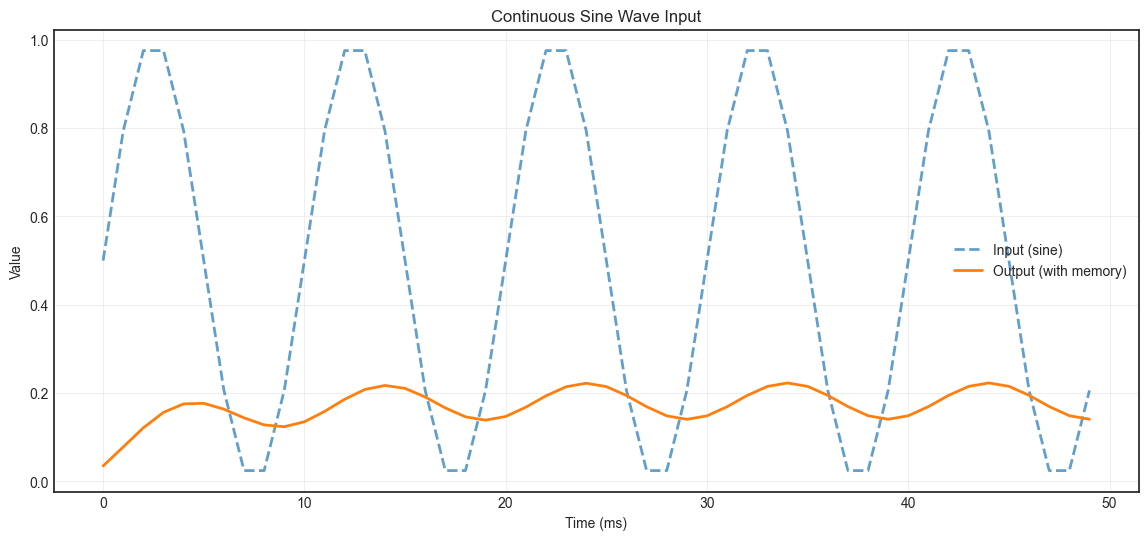

Input range: 0.024 to 0.976
Output range: 0.035 to 0.223
Points processed: 50


In [6]:
# Sine wave input
total_time = 50.0  # 50ms total
time_step = 1.0    # 1ms steps
times = np.arange(0, total_time, time_step)

# Generate sine wave
frequency = 0.1  # cycles per ms
sine_inputs = np.sin(2 * np.pi * frequency * times) * 0.5 + 0.5  # Scale to [0,1]

# Reset state
prev_states = np.zeros(1, dtype=np.float64)
prev_time = 0.0

outputs = []

for t, inp in zip(times, sine_inputs):
    x_vector = np.array([inp], dtype=np.float64)
    inputs_tuple = (t, x_vector)
    
    output, prev_states, _ = predict_individual(
        parameters, layer_sizes, activations, inputs_tuple,
        prev_states, prev_time, param_indices, neuron_indices
    )
    
    outputs.append(output[0])
    prev_time = t

# Plot
plt.figure(figsize=(14, 6))
plt.plot(times, sine_inputs, '--', alpha=0.7, label='Input (sine)', linewidth=2)
plt.plot(times, outputs, '-', label='Output (with memory)', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Value')
plt.title('Continuous Sine Wave Input')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Input range: {min(sine_inputs):.3f} to {max(sine_inputs):.3f}")
print(f"Output range: {min(outputs):.3f} to {max(outputs):.3f}")
print(f"Points processed: {len(outputs)}")

## Test Complex Network Performance

Let's test a much larger network: 10 → 50 → 80 → 30 → 5 (3 hidden layers)

In [7]:
import time
from numba_ga import get_total_parameters

# Complex network: 10 → 50 → 80 → 30 → 5
complex_layer_sizes = np.array([10, 50, 80, 30, 5], dtype=np.int64)
complex_activations = np.array([1, 2, 3, 1], dtype=np.int64)  # ReLU, Sigmoid, Tanh, ReLU

# Initialize complex network
complex_params = initialize_parameters(complex_layer_sizes, seed=123)
complex_param_indices, complex_neuron_indices = compute_layer_indices(complex_layer_sizes)

# Network statistics
total_params = get_total_parameters(complex_layer_sizes)
total_neurons = sum(complex_layer_sizes[1:])  # Hidden + output neurons

print(f"🧠 Complex Network Architecture: {list(complex_layer_sizes)}")
print(f"📊 Network Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Total neurons: {total_neurons}")
print(f"   Layers: {len(complex_layer_sizes)}")
print(f"   Activations: ReLU → Sigmoid → Tanh → ReLU")

# Calculate parameter breakdown
print(f"\\n📈 Parameter Breakdown:")
for i in range(len(complex_layer_sizes) - 1):
    from_size = complex_layer_sizes[i]
    to_size = complex_layer_sizes[i + 1]
    weights = from_size * to_size
    biases = to_size
    alphas = to_size
    layer_total = weights + biases + alphas
    print(f"   Layer {i+1} ({from_size}→{to_size}): {layer_total:,} params (W:{weights}, B:{biases}, α:{alphas})")

🧠 Complex Network Architecture: [np.int64(10), np.int64(50), np.int64(80), np.int64(30), np.int64(5)]
📊 Network Statistics:
   Total parameters: 7,380
   Total neurons: 165
   Layers: 5
   Activations: ReLU → Sigmoid → Tanh → ReLU
\n📈 Parameter Breakdown:
   Layer 1 (10→50): 600 params (W:500, B:50, α:50)
   Layer 2 (50→80): 4,160 params (W:4000, B:80, α:80)
   Layer 3 (80→30): 2,460 params (W:2400, B:30, α:30)
   Layer 4 (30→5): 160 params (W:150, B:5, α:5)


In [8]:
# Performance benchmarking
print(f"\\n⚡ Performance Benchmarking:")

# Test input
test_input = np.random.randn(10).astype(np.float64)
test_time = 10.0
test_inputs_tuple = (test_time, test_input)

# Initialize state
complex_prev_states = np.zeros(total_neurons, dtype=np.float64)
complex_prev_time = 0.0

# Warm-up run (JIT compilation)
print("   Warming up JIT compilation...")
for _ in range(5):
    output, complex_prev_states, _ = predict_individual(
        complex_params, complex_layer_sizes, complex_activations, test_inputs_tuple,
        complex_prev_states, complex_prev_time, complex_param_indices, complex_neuron_indices
    )

# Benchmark runs
num_runs = 1000
print(f"   Running {num_runs} predictions...")

start_time = time.time()
for i in range(num_runs):
    # Vary input slightly each time
    varied_input = test_input + np.random.randn(10) * 0.1
    varied_time = test_time + i * 0.1
    varied_inputs_tuple = (varied_time, varied_input)
    
    output, complex_prev_states, _ = predict_individual(
        complex_params, complex_layer_sizes, complex_activations, varied_inputs_tuple,
        complex_prev_states, complex_prev_time, complex_param_indices, complex_neuron_indices
    )
    complex_prev_time = varied_time

end_time = time.time()
total_time = (end_time - start_time) * 1000  # Convert to ms

print(f"\\n📈 Performance Results:")
print(f"   Total time: {total_time:.2f} ms")
print(f"   Average per prediction: {total_time/num_runs:.4f} ms")
print(f"   Predictions per second: {num_runs/(total_time/1000):.0f}")
print(f"   Parameters per prediction: {total_params:,}")
print(f"   Params/ms throughput: {(total_params * num_runs) / total_time:.0f}")

print(f"\\n🎯 Final Output Shape: {output.shape}")
print(f"   Output values: {output}")

\n⚡ Performance Benchmarking:
   Warming up JIT compilation...
   Running 1000 predictions...
\n📈 Performance Results:
   Total time: 5.84 ms
   Average per prediction: 0.0058 ms
   Predictions per second: 171210
   Parameters per prediction: 7,380
   Params/ms throughput: 1263530
\n🎯 Final Output Shape: (5,)
   Output values: [0.06936724 0.         1.29399375 0.28464033 1.63439116]


\n🧪 Testing Complex Network with Temporal Patterns:


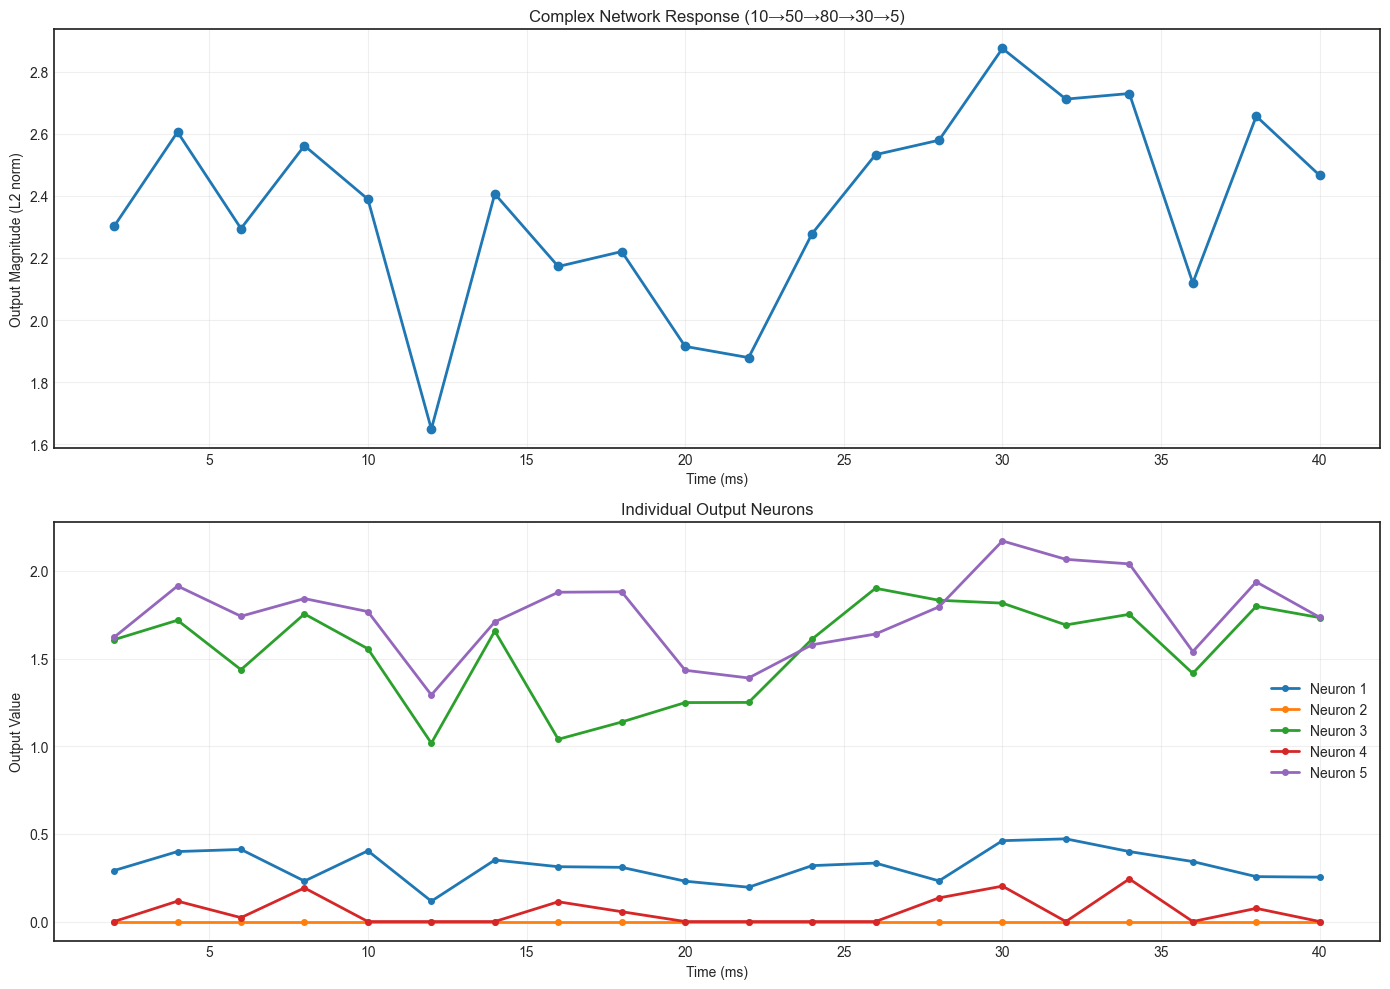

\n📊 Complex Network Results:
   Pattern length: 20 steps
   Input dimensions: 10
   Output dimensions: 5
   Output magnitude range: 1.649 to 2.875
   Final output: [0.25325808 0.         1.73362644 0.         1.7352533 ]
   Memory state size: 165 neurons


In [9]:
# Test complex network with temporal patterns
print(f"\\n🧪 Testing Complex Network with Temporal Patterns:")

# Create multi-dimensional input pattern
pattern_length = 20
time_step = 2.0  # 2ms steps

# Generate complex input pattern (10-dimensional)
np.random.seed(42)
complex_pattern = np.random.choice([0.0, 1.0], size=(pattern_length, 10))

# Reset state
complex_prev_states = np.zeros(total_neurons, dtype=np.float64)
complex_prev_time = 0.0
current_time = 0.0

complex_times = []
complex_outputs = []
output_magnitudes = []

for step in range(pattern_length):
    current_time += time_step
    
    # Get input vector for this step
    input_vector = complex_pattern[step].astype(np.float64)
    inputs_tuple = (current_time, input_vector)
    
    # Predict
    output, complex_prev_states, _ = predict_individual(
        complex_params, complex_layer_sizes, complex_activations, inputs_tuple,
        complex_prev_states, complex_prev_time, complex_param_indices, complex_neuron_indices
    )
    
    complex_times.append(current_time)
    complex_outputs.append(output.copy())
    output_magnitudes.append(np.linalg.norm(output))  # L2 norm of output vector
    
    complex_prev_time = current_time

# Visualize complex network response
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Output magnitude over time
ax1.plot(complex_times, output_magnitudes, 'o-', linewidth=2, markersize=6)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Output Magnitude (L2 norm)')
ax1.set_title(f'Complex Network Response (10→50→80→30→5)')
ax1.grid(True, alpha=0.3)

# Plot 2: Individual output neurons
complex_outputs_array = np.array(complex_outputs)
for i in range(5):  # 5 output neurons
    ax2.plot(complex_times, complex_outputs_array[:, i], 'o-', label=f'Neuron {i+1}', linewidth=2, markersize=4)

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Output Value')
ax2.set_title('Individual Output Neurons')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\n📊 Complex Network Results:")
print(f"   Pattern length: {pattern_length} steps")
print(f"   Input dimensions: {complex_pattern.shape[1]}")
print(f"   Output dimensions: {output.shape[0]}")
print(f"   Output magnitude range: {min(output_magnitudes):.3f} to {max(output_magnitudes):.3f}")
print(f"   Final output: {output}")
print(f"   Memory state size: {complex_prev_states.shape[0]} neurons")

## Test Population Prediction

Test the `predict_population` function with multiple individuals and compare their responses to the same input patterns.

In [10]:
from numba_ga import initialize_population, predict_population, reset_population_memory

# Create population of simple networks for comparison
pop_size = 8
simple_layer_sizes = np.array([1, 1], dtype=np.int64)  # Keep it simple for visualization
simple_activations = np.array([3], dtype=np.int64)  # Tanh

# Initialize population
population = initialize_population(pop_size, simple_layer_sizes, seed=456)

# Set different alpha values for each individual to see diversity
for i in range(pop_size):
    population[i, 2] = 0.1 + i * 0.1  # Alpha from 0.2 to 0.9

# Initialize population memory states
pop_states, pop_times = reset_population_memory(simple_layer_sizes, pop_size)

print(f"🧬 Population Test Setup:")
print(f"   Population size: {pop_size}")
print(f"   Network architecture: {list(simple_layer_sizes)}")
print(f"   Individual alpha values: {[population[i, 2] for i in range(pop_size)]}")

# Test with alternating pattern
pattern = '1010101010'
time_step = 5.0

all_times = []
all_population_outputs = []

current_time = 0.0

for bit_char in pattern:
    current_time += time_step
    
    # Same input for all individuals
    input_val = float(bit_char)
    x_vector = np.array([input_val], dtype=np.float64)
    inputs_tuple = (current_time, x_vector)
    
    # Predict for entire population
    outputs, pop_states, pop_times = predict_population(
        population, simple_layer_sizes, simple_activations, inputs_tuple,
        pop_states, pop_times
    )
    
    all_times.append(current_time)
    all_population_outputs.append(outputs.copy())

# Convert to array for easier plotting
all_population_outputs = np.array(all_population_outputs)  # Shape: (time_steps, pop_size, 1)
all_population_outputs = all_population_outputs[:, :, 0]  # Remove last dimension

print(f"\\n📊 Population Response Data:")
print(f"   Time steps: {len(all_times)}")
print(f"   Output shape: {all_population_outputs.shape}")
print(f"   Pattern tested: {pattern}")

🧬 Population Test Setup:
   Population size: 8
   Network architecture: [np.int64(1), np.int64(1)]
   Individual alpha values: [np.float64(0.1), np.float64(0.2), np.float64(0.30000000000000004), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7000000000000001), np.float64(0.8)]
\n📊 Population Response Data:
   Time steps: 10
   Output shape: (10, 8)
   Pattern tested: 1010101010


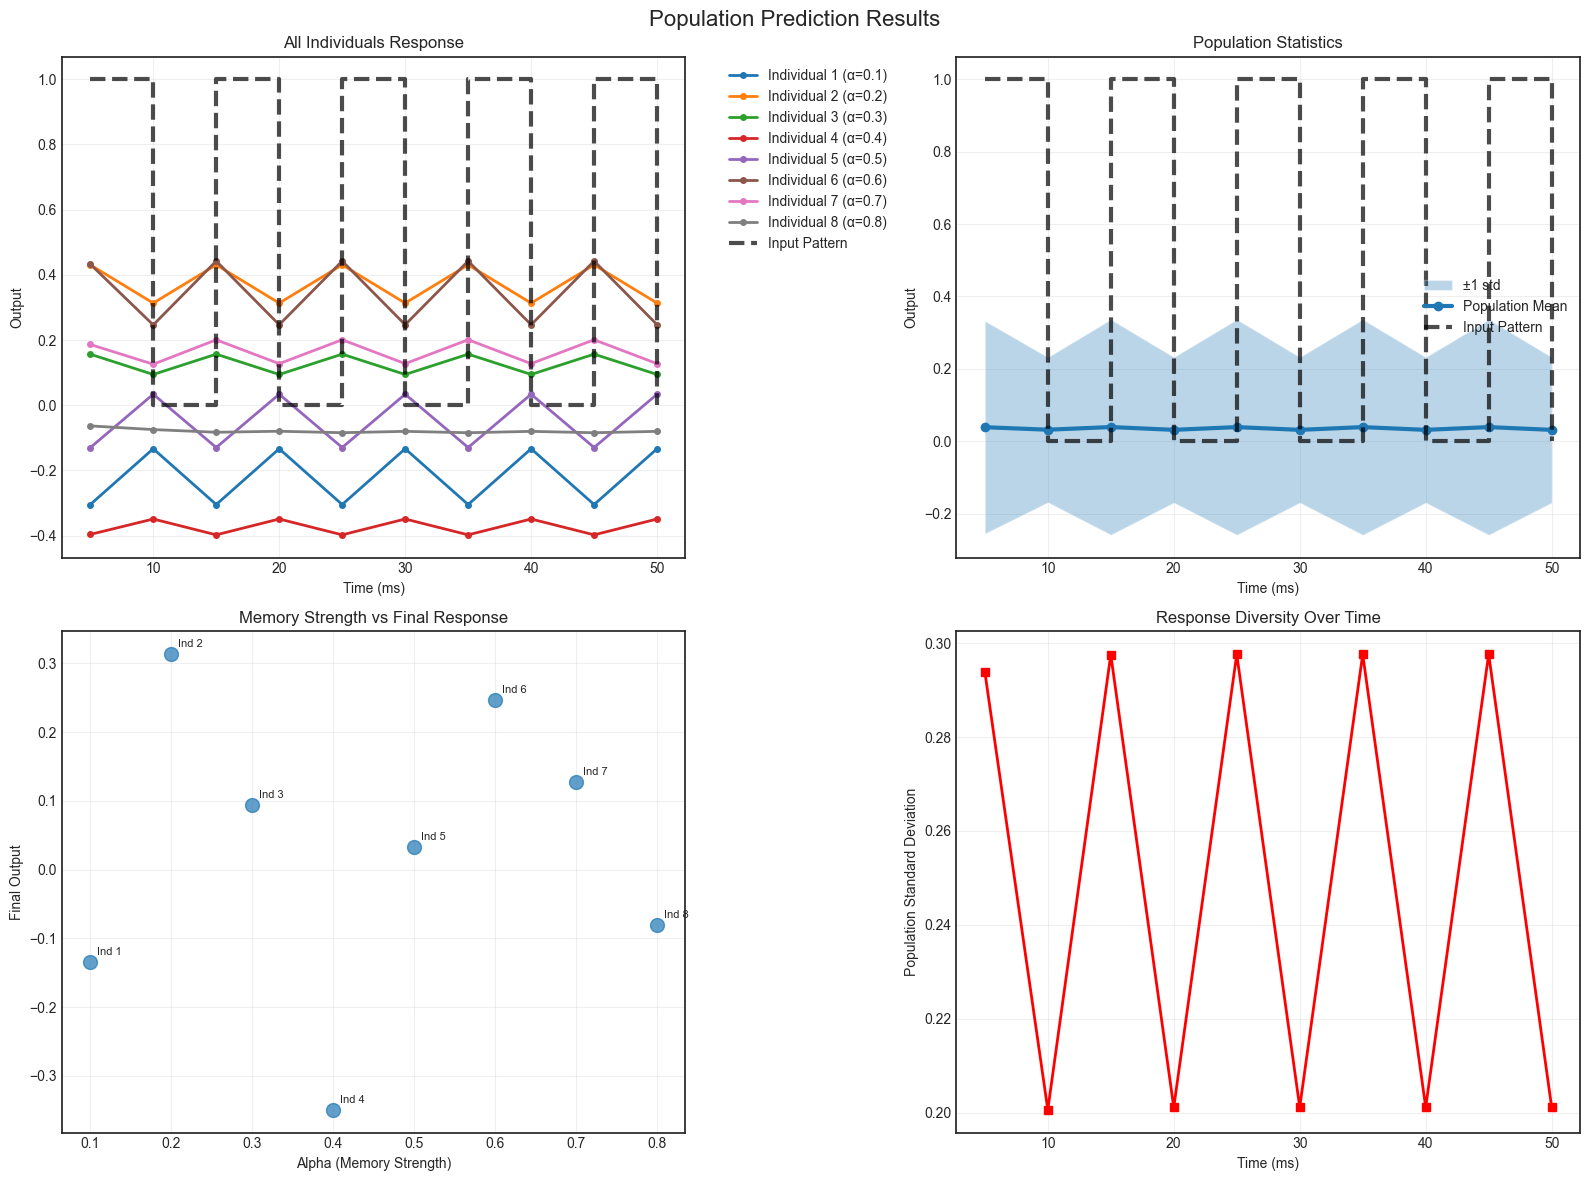

\n📈 Population Analysis:
   Alpha range: 0.1 to 0.8
   Final output range: -0.349 to 0.313
   Population diversity (final std): 0.201
   Mean final output: 0.032
\n👥 Individual Final Outputs:
   Individual 1 (α=0.1): -0.1337
   Individual 2 (α=0.2): 0.3133
   Individual 3 (α=0.3): 0.0942
   Individual 4 (α=0.4): -0.3493
   Individual 5 (α=0.5): 0.0336
   Individual 6 (α=0.6): 0.2468
   Individual 7 (α=0.7): 0.1274
   Individual 8 (α=0.8): -0.0803


In [11]:
# Visualize population diversity
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Population Prediction Results', fontsize=16)

# Plot 1: All individuals over time
ax1 = axes[0, 0]
for i in range(pop_size):
    alpha_val = population[i, 2]
    ax1.plot(all_times, all_population_outputs[:, i], 'o-', 
             label=f'Individual {i+1} (α={alpha_val:.1f})', linewidth=2, markersize=4)

# Add input pattern as reference
input_pattern = [float(bit) for bit in pattern]
ax1.step(all_times, input_pattern, where='post', color='black', linewidth=3, 
         alpha=0.7, label='Input Pattern', linestyle='--')

ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Output')
ax1.set_title('All Individuals Response')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Average response vs individual spread
ax2 = axes[0, 1]
mean_response = np.mean(all_population_outputs, axis=1)
std_response = np.std(all_population_outputs, axis=1)

ax2.fill_between(all_times, mean_response - std_response, mean_response + std_response, 
                 alpha=0.3, label='±1 std')
ax2.plot(all_times, mean_response, 'o-', linewidth=3, markersize=6, label='Population Mean')
ax2.step(all_times, input_pattern, where='post', color='black', linewidth=3, 
         alpha=0.7, label='Input Pattern', linestyle='--')

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Output')
ax2.set_title('Population Statistics')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Alpha vs final response
ax3 = axes[1, 0]
alpha_values = [population[i, 2] for i in range(pop_size)]
final_outputs = all_population_outputs[-1, :]  # Last time step

ax3.scatter(alpha_values, final_outputs, s=100, alpha=0.7)
for i, (alpha, output) in enumerate(zip(alpha_values, final_outputs)):
    ax3.annotate(f'Ind {i+1}', (alpha, output), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)

ax3.set_xlabel('Alpha (Memory Strength)')
ax3.set_ylabel('Final Output')
ax3.set_title('Memory Strength vs Final Response')
ax3.grid(True, alpha=0.3)

# Plot 4: Response diversity over time
ax4 = axes[1, 1]
response_std_over_time = np.std(all_population_outputs, axis=1)
ax4.plot(all_times, response_std_over_time, 's-', linewidth=2, markersize=6, color='red')
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Population Standard Deviation')
ax4.set_title('Response Diversity Over Time')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print population statistics
print(f"\\n📈 Population Analysis:")
print(f"   Alpha range: {min(alpha_values):.1f} to {max(alpha_values):.1f}")
print(f"   Final output range: {min(final_outputs):.3f} to {max(final_outputs):.3f}")
print(f"   Population diversity (final std): {np.std(final_outputs):.3f}")
print(f"   Mean final output: {np.mean(final_outputs):.3f}")

print(f"\\n👥 Individual Final Outputs:")
for i in range(pop_size):
    print(f"   Individual {i+1} (α={alpha_values[i]:.1f}): {final_outputs[i]:.4f}")

In [12]:
# Performance test for predict_population
print(f"\\n⚡ Population Prediction Performance Test:")

# Create larger population for performance testing
large_pop_size = 100
large_population = initialize_population(large_pop_size, simple_layer_sizes, seed=789)
large_pop_states, large_pop_times = reset_population_memory(simple_layer_sizes, large_pop_size)

# Test input
test_input = np.array([0.5], dtype=np.float64)
test_time = 10.0
test_inputs_tuple = (test_time, test_input)

# Warm-up
print(f"   Warming up population prediction (size={large_pop_size})...")
for _ in range(3):
    outputs, large_pop_states, large_pop_times = predict_population(
        large_population, simple_layer_sizes, simple_activations, test_inputs_tuple,
        large_pop_states, large_pop_times
    )

# Benchmark population prediction
num_pop_runs = 500
print(f"   Running {num_pop_runs} population predictions...")

start_time = time.time()
for i in range(num_pop_runs):
    varied_input = test_input + np.random.randn(1) * 0.1
    varied_time = test_time + i * 0.1
    varied_inputs_tuple = (varied_time, varied_input)
    
    outputs, large_pop_states, large_pop_times = predict_population(
        large_population, simple_layer_sizes, simple_activations, varied_inputs_tuple,
        large_pop_states, large_pop_times
    )

end_time = time.time()
pop_total_time = (end_time - start_time) * 1000  # Convert to ms

# Calculate equivalent individual predictions
total_individual_predictions = large_pop_size * num_pop_runs

print(f"\\n📊 Population Performance Results:")
print(f"   Population size: {large_pop_size}")
print(f"   Number of runs: {num_pop_runs}")
print(f"   Total time: {pop_total_time:.2f} ms")
print(f"   Time per population: {pop_total_time/num_pop_runs:.4f} ms")
print(f"   Time per individual: {pop_total_time/total_individual_predictions:.6f} ms")
print(f"   Population predictions/sec: {num_pop_runs/(pop_total_time/1000):.0f}")
print(f"   Individual predictions/sec: {total_individual_predictions/(pop_total_time/1000):.0f}")

print(f"\\n🎯 Final Population Output:")
print(f"   Output shape: {outputs.shape}")
print(f"   Sample outputs: {outputs[:5, 0]}")  # First 5 individuals

\n⚡ Population Prediction Performance Test:
   Warming up population prediction (size=100)...
   Running 500 population predictions...
\n📊 Population Performance Results:
   Population size: 100
   Number of runs: 500
   Total time: 10.26 ms
   Time per population: 0.0205 ms
   Time per individual: 0.000205 ms
   Population predictions/sec: 48723
   Individual predictions/sec: 4872339
\n🎯 Final Population Output:
   Output shape: (100, 1)
   Sample outputs: [-0.31448432  0.13158211 -0.1704717   0.34930656 -0.130383  ]


## Summary

This notebook shows how the simple 1→1 time-aware neural network responds to different inputs:

- **Binary patterns**: Memory causes persistence between pulses
- **Time gaps**: Longer gaps → more memory decay → output closer to fresh response  
- **Alpha values**: Higher alpha → stronger memory → more temporal coupling
- **Continuous input**: Smooth temporal dynamics with memory integration

All using the production `numba_ga.py` functions directly! 🚀